# Lab 8: Naive Bayes & Review

## Simple Bayesian Classifiction


### [Haiping Lu](http://staffwww.dcs.shef.ac.uk/people/H.Lu/) -  [COM4509/6509 MLAI2019](https://github.com/maalvarezl/MLAI)

* This notebook is a modified version of the [Naive Bayes notebook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.05-Naive-Bayes.ipynb) from the [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook) by Jake VanderPlas

* In consideration of the incoming Quiz 2 and Assignment 2, no question is set in this lab. Only some exercises are suggested for those interested to explore further.

* After completing Lab 8, you are suggested to review Lab 6 and Lab 7 in preparation for your **Quiz 2 on Friday 22nd Nov**.


In [Lab 6](https://github.com/maalvarezl/MLAI/blob/master/Lab%206%20-%20Bayesian%20regression%20%26%20DL%20intro.ipynb), we studied Bayesian *regression*. Here, we study Bayesian *classification* in the simplest form.

[Naive Bayes classifiers](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets. Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem. This notebook will focus on an intuitive explanation of how naive Bayes classifiers work, followed by a couple examples of them in action on some datasets.

## 1. Naive Bayes

### 1.1 Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods.
These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities.
In Bayesian classification, we're interested in finding the probability of a class given some observed features, which we can write as $P(C~|~{\rm features})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(C~|~{\rm features}) = \frac{P({\rm features}~|~C)P(C)}{P({\rm features})}
$$

If we are trying to decide between two classes—let's call them $C_1$ and $C_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each class:

$$
\frac{P(C_1~|~{\rm features})}{P(C_2~|~{\rm features})} = \frac{P({\rm features}~|~C_1)}{P({\rm features}~|~C_2)}\frac{P(C_1)}{P(C_2)}
$$

All we need now is some model by which we can compute $P({\rm features}~|~C_i)$ for each class.
Such a model is called a [**generative model**](https://en.wikipedia.org/wiki/Generative_model) because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each class is the main piece of the training of such a Bayesian classifier.
The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model.

### 1.2 Naive Bayes Classifier

This is where the "naive" in "naive Bayes" comes in: if we make very naive assumptions about the generative model for each class, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification. In Naive Bayes, we assume that the **features are independent given (conditioned on) the class label**. Thus, we just need to model the distribution of a single feature. If each feaure is binary valued, we can use the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution). If each feature is a continuous value, we can use the Gaussian distribution and this version is called Gaussian Naive Bayes below.

<!--**Note**: however, naive Bayes is not (necessarily) a Bayesian (inference) method. It does not (have to) place a prior distribution on the model parameters. If interested, check out the two refernces in wikipedia or [this discussiona at stackexchange](https://stats.stackexchange.com/questions/180582/when-is-a-naive-bayes-model-not-bayesian). -->

We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # for statistical data visualization

### 1.3 Gaussian Naive Bayes

Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes.
In this classifier, the assumption is that **data from each class** is drawn from a simple Gaussian distribution.
Imagine that you have the following 100 labelled data points with two features each:

(100, 2)


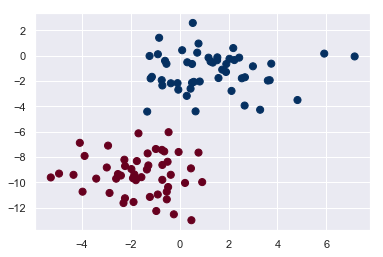

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
print(X.shape)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

#### Data Independence Conditioned on Class
One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution  are independent given (conditioned on) the class label. This model can be fit by simply finding the mean and standard deviation of the points within each class, which is all you need to define such a distribution. The result of this naive Gaussian assumption is shown in the following figure:

[(-15, 5), (-8, 8)]

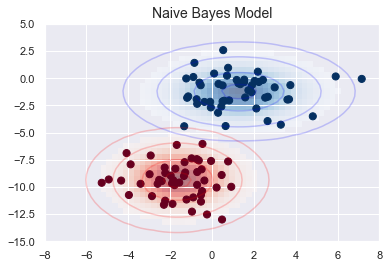

In [3]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0) #Estimate the mean and variance from the data
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

The ellipses here represent the Gaussian generative model for each class, with larger probability toward the center of the ellipses.
With this generative model in place for each class, we have a simple recipe to compute the likelihood $P({\rm features}~|~C_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which class is the most probable for a given point.

This procedure is implemented in Scikit-Learn's ``sklearn.naive_bayes.GaussianNB`` estimator (if you have not, install scikit-learn via <code>conda install scikit-learn</code>):

In [4]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

Now let's generate some new data and predict the class:

In [5]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)  #the numbers are to control the x,y limits
ynew = model.predict(Xnew)
Xnew.shape

(2000, 2)

Now we can plot this new data to get an idea of where the decision boundary is:

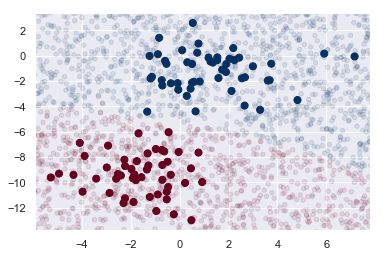

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

We see a slightly curved boundary in the classifications—in general, the boundary in Gaussian naive Bayes is quadratic.

A nice piece of this Bayesian formalism is that it naturally allows for probabilistic classification, i.e., predicting the probability of belonging to a class. We can compute using the [``predict_proba`` method](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.predict_proba):

In [7]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

The columns give the posterior probabilities of the first and second class, respectively.
If you are looking for estimates of **uncertainty** in your classification, Bayesian approaches like this can be a useful approach.

Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results.
Still, in many cases—especially as the number of features becomes large—this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a useful method.

### 1.4 Multinomial Naive Bayes for Text Classification

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each class.
Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution).
The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.Here we will use the sparse word count features from the [20 Newsgroups corpus](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [8]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups('./data/20news')
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [9]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)
train.target_names

['comp.graphics', 'sci.space', 'soc.religion.christian', 'talk.religion.misc']

Here is a representative entry from the data:

In [10]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers. For this we will use the [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) vectorizer, and create a **pipeline** that attaches it to a multinomial naive Bayes classifier:

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

**Note**: TF-IDF is not in the scope of this module (it should be covered in NLP related modules instead). Here, we just expect you to know how to use it as a function.

With this pipeline, we can apply the model to the training data, and predict class labels for the test data:

In [12]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now that we have predicted the class labels for the test data, we can evaluate them to learn about the performance of the estimator.
For example, here is the confusion matrix between the true and predicted class labels for the test data:

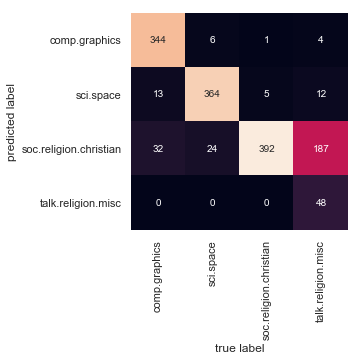

In [13]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidently, even this very simple classifier can successfully separate space talk from computer talk, but it gets confused between talk about religion and talk about Christianity.
This is perhaps an expected area of confusion!

The very cool thing here is that we now have the tools to determine the category for *any* string, using the ``predict()`` method of this pipeline.
Here's a quick utility function that will return the prediction for a single string:

In [14]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Let's try it out:

In [15]:
predict_category('sending a payload to the ISS')

'sci.space'

In [16]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [17]:
predict_category('determining the screen resolution')

'comp.graphics'

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking.
Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

## 2. When to Use Naive Bayes

Because naive Bayes classifiers make stringent assumptions about data, they will generally not perform as well as a more complicated model when sufficient data is available.
That said, they have several advantages:

- They are extremely fast for both training and prediction
- They provide straightforward probabilistic prediction
- They are often very easily interpretable
- They have very few (if any) tunable parameters

These advantages mean a naive Bayes classifier is often a good choice as an initial baseline classification.
If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem.
If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in one of the following situations:

- When the naive assumptions actually match the data (very rare in practice)
- For very well-separated categories, when model complexity is less important
- For very high-dimensional data, when model complexity is less important

The last two points seem distinct, but they actually are related: as the dimension of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in *every single dimension* to be close overall).
This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information.
For this reason, simplistic classifiers like naive Bayes tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.

## 3. Review Lab 6 and Lab7


## 4. Exercises


* Use linear regression to do the prediction, i.e., treating the class labels as the response to predict, and compare the results with Naive Bayes
* Follow [this notebook on Naive Bayes](http://jonathansoma.com/lede/foundations/classes/classification/naive-bayes.ipynb). I did not find the data in this notebook but think you can use similar data at [Kaggle "What's Cooking?" kernel](https://www.kaggle.com/c/whats-cooking-kernels-only/data) in JSON format. An example of manipulation this data is [here](https://flothesof.github.io/probabilistic-ingredients.html). You will learn **pandas** so a [10-min tutorial](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html) should be helpful.

## 5. Further Reading
* [Naive Bayes and Text Classification](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)
* [Applying Multinomial Naive Bayes to NLP Problems: A Practical Explanation](https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf)
